## Warmstart + Mitiq + Error Mitigation + Noise Backend + Optuna (IBM)

In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [1]:
import qiskit
provider = qiskit.IBMQ.load_account()

In [ ]:
import optuna
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, SlsqpOptimizer, CobylaOptimizer
from qiskit.ignis.mitigation import CompleteMeasFitter

from shared.QiskitMaxcut import *
from shared.Mitiq_QAOA import *
from ibm.ibm_parameters import *
%matplotlib inline

In [2]:
print_parameters()

In [ ]:
# ---- Define graph and MaxCut ----
graph = load_graph()
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [20]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS,
                    noise_model=noise_model,
                    coupling_map=coupling_map,
                    basis_gates=basis_gates,
                    measurement_error_mitigation_cls=CompleteMeasFitter,
                    measurement_error_mitigation_shots=SHOTS
    )

    # generate QAOA to get circuit
    pre_qaoa = QAOA(optimizer=COBYLA(maxiter=1, tol=0), quantum_instance=quantum_instance, reps=reps, initial_point=init_parameters)
    MinimumEigenOptimizer(pre_qaoa).solve(max_cut_qubo)

    circuit = pre_qaoa.get_optimal_circuit()
    circuit.measure_all()

    if optimizer == "QN-SPSA":
        fidelity = QNSPSA.get_fidelity(pre_qaoa.ansatz)
        optimizer = QNSPSA(fidelity, maxiter=MAX_ITER)

    mitiq_qaoa = Mitiq_QAOA(mitiq_circuit=circuit.copy(),
                            optimizer=optimizer,
                            quantum_instance=quantum_instance,
                            reps=reps,
                            initial_point=init_parameters)

    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=SlsqpOptimizer(),
                                     relax_for_pre_solver=True,
                                     qaoa=mitiq_qaoa)

    return ws_qaoa

In [21]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    result = qaoa.solve(max_cut_problem)
    optimal_parameters = qaoa._qaoa.optimal_params
    return result, optimal_parameters.copy()

In [22]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]

    qaoa = init_qaoa(optimizer, reps, parameters)

    result, optimal_parameters = run(max_cut_qubo, qaoa)

    mean, distribution = max_cut.analyse(result)

    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters, optimizer_name])

    return mean

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-22 17:23:21,501] A new study created in memory with name: no-name-91895096-bad2-4807-989b-4364ae266b51
[I 2021-07-22 17:24:06,589] Trial 0 finished with value: -25.014766057576466 and parameters: {'optimizer': 'COBYLA', 'reps': 6, 'gamma_0': 0.6401019190511641, 'gamma_1': -1.3354332041188237, 'gamma_2': -2.5961714966283007, 'gamma_3': -1.1145033562286382, 'gamma_4': 1.2204918150033786, 'gamma_5': 3.042513573407348, 'beta_0': 2.6276991111211307, 'beta_1': 2.2824419438071555, 'beta_2': -0.3396473328779859, 'beta_3': 2.908431156465901, 'beta_4': 2.1878548189406724, 'beta_5': 2.928898853551183}. Best is trial 0 with value: -25.014766057576466.
[I 2021-07-22 17:26:11,959] Trial 1 finished with value: -24.369168563746264 and parameters: {'optimizer': 'SPSA', 'reps': 7, 'gamma_0': -1.1095968984467222, 'gamma_1': -1.2991053963516868, 'gamma_2': 2.178471726650698, 'gamma_3': -1.8502988420613211, 'gamma_4': -1.8546632432503503, 'gamma_5': 0.05216491469917184, 'gamma_6': -0.25314593846

[I 2021-07-22 17:38:47,381] Trial 16 finished with value: -24.424581563866774 and parameters: {'optimizer': 'COBYLA', 'reps': 10, 'gamma_0': -1.5404293999949135, 'gamma_1': 0.04607688498772833, 'gamma_2': -1.0130481942866885, 'gamma_3': 0.819902156710284, 'gamma_4': -3.127261644311579, 'gamma_5': -2.2504375860759733, 'gamma_6': 2.972928521257481, 'gamma_7': -3.1026074273350734, 'gamma_8': -2.205494099774731, 'gamma_9': -2.258704241113303, 'beta_0': 2.0096976672696822, 'beta_1': 2.313282765781732, 'beta_2': -1.5524970965820197, 'beta_3': -1.6162149623918123, 'beta_4': 0.5648991401205841, 'beta_5': 0.4318604222913942, 'beta_6': -2.989295695523539, 'beta_7': 3.0894655310702954, 'beta_8': -2.906112799573757, 'beta_9': 3.0327073463573644}. Best is trial 7 with value: -27.362185178463736.
[I 2021-07-22 17:39:30,969] Trial 17 finished with value: -25.993773318313337 and parameters: {'optimizer': 'COBYLA', 'reps': 6, 'gamma_0': -3.05749210043691, 'gamma_1': 3.048536291887529, 'gamma_2': 1.8075

[I 2021-07-22 17:50:05,353] Trial 32 finished with value: -25.827306664278076 and parameters: {'optimizer': 'COBYLA', 'reps': 7, 'gamma_0': 2.327826773037816, 'gamma_1': -1.269798056537351, 'gamma_2': -0.5193207207524115, 'gamma_3': 2.5535335614691315, 'gamma_4': 0.4440836101989865, 'gamma_5': -1.3091120780030319, 'gamma_6': 2.760359131670044, 'beta_0': -0.5812897817469747, 'beta_1': -0.33128685566476673, 'beta_2': -0.5820127636889981, 'beta_3': -0.692858353357811, 'beta_4': 0.3826924104967677, 'beta_5': 1.446550853841949, 'beta_6': 1.8060853882591845}. Best is trial 29 with value: -28.8784144081116.
[I 2021-07-22 17:50:59,195] Trial 33 finished with value: -26.634822377118702 and parameters: {'optimizer': 'COBYLA', 'reps': 8, 'gamma_0': 0.6744847655827286, 'gamma_1': -1.686624668272246, 'gamma_2': -1.5795245548334236, 'gamma_3': 1.891010216992688, 'gamma_4': 1.4550593221622106, 'gamma_5': -0.8201351884945315, 'gamma_6': -1.3785132261282405, 'gamma_7': -1.5089118017112382, 'beta_0': -1

[I 2021-07-22 18:03:57,078] Trial 45 finished with value: -25.10790495217144 and parameters: {'optimizer': 'COBYLA', 'reps': 8, 'gamma_0': 2.014140579722379, 'gamma_1': -1.9087583166057052, 'gamma_2': 0.3934619909801941, 'gamma_3': 3.1126092717689016, 'gamma_4': 1.7510688956966232, 'gamma_5': -0.30096374689616123, 'gamma_6': 1.4593509817172372, 'gamma_7': 1.2889151934201584, 'beta_0': 2.3169624604419425, 'beta_1': -2.812565442316376, 'beta_2': -2.9587360371539697, 'beta_3': 0.1633926012691093, 'beta_4': -0.318460608707857, 'beta_5': 0.9312049075420326, 'beta_6': 2.3656293930598316, 'beta_7': 0.2889115044822055}. Best is trial 29 with value: -28.8784144081116.
[I 2021-07-22 18:04:55,909] Trial 46 finished with value: -27.43853353731033 and parameters: {'optimizer': 'COBYLA', 'reps': 9, 'gamma_0': 0.31105831565085795, 'gamma_1': -1.3762225013251976, 'gamma_2': -2.407824286026186, 'gamma_3': 2.098004731786642, 'gamma_4': 2.5943029647879907, 'gamma_5': -1.8997329338327296, 'gamma_6': 2.280

In [25]:
print(study.best_trial)

FrozenTrial(number=29, values=[-28.8784144081116], datetime_start=datetime.datetime(2021, 7, 22, 17, 47, 19, 89182), datetime_complete=datetime.datetime(2021, 7, 22, 17, 48, 2, 638373), params={'optimizer': 'COBYLA', 'reps': 6, 'gamma_0': 1.4794730080461513, 'gamma_1': -0.6882987741426103, 'gamma_2': -0.8998980494921142, 'gamma_3': 2.5463408929068403, 'gamma_4': 0.5793443848866693, 'gamma_5': -1.110419656732657, 'beta_0': 0.07344966491396396, 'beta_1': -0.6728838759585384, 'beta_2': 1.0731656249025463, 'beta_3': -1.9496488463638753, 'beta_4': 0.20236920641562428, 'beta_5': 1.7311059184627515}, distributions={'optimizer': CategoricalDistribution(choices=('SPSA', 'COBYLA')), 'reps': IntUniformDistribution(high=10, low=1, step=1), 'gamma_0': UniformDistribution(high=3.141592653589793, low=-3.141592653589793), 'gamma_1': UniformDistribution(high=3.141592653589793, low=-3.141592653589793), 'gamma_2': UniformDistribution(high=3.141592653589793, low=-3.141592653589793), 'gamma_3': UniformDist

In [26]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params, optimizer_name = study.user_attrs["best"]
print(f"Optimizer: {optimizer_name}")
print(f"Optimal Parameters: {optimal_params}")

In [27]:
max_cut.draw(result)

array([ 2.54688176, -0.93615441, -0.7789562 ,  3.4777998 ,  0.31144345,
       -0.09676931,  0.0675467 ,  0.30564694,  1.05463352, -1.98108075,
        0.220484  ,  1.69062969])

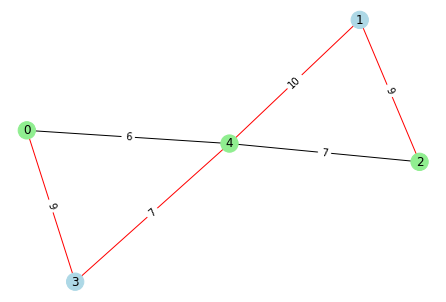

In [28]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

optimal function value: 35.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS
Mean: 28.8784144081116
01010: value: 35.000, probability: 6.8%
10101: value: 35.000, probability: 6.6%
00111: value: 34.000, probability: 2.7%
11000: value: 34.000, probability: 2.8%
01110: value: 33.000, probability: 2.0%
10001: value: 33.000, probability: 2.3%
00011: value: 32.000, probability: 11.4%
00101: value: 32.000, probability: 8.3%
00110: value: 32.000, probability: 1.7%
11001: value: 32.000, probability: 1.6%
11010: value: 32.000, probability: 8.4%
11100: value: 32.000, probability: 11.4%
01011: value: 31.000, probability: 5.0%
10100: value: 31.000, probability: 5.2%
00001: value: 30.000, probability: 1.0%
11110: value: 30.000, probability: 1.2%
01001: value: 29.000, probability: 1.1%
10110: value: 29.000, probability: 1.0%
01000: value: 19.000, probability: 1.0%
10111: value: 19.000, probability: 1.1%
01100: value: 17.000, probability: 2.4%
10011: value: 17.000, probability: 2.6%
00010: value: 16.0

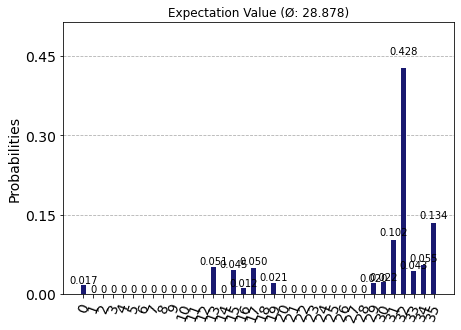

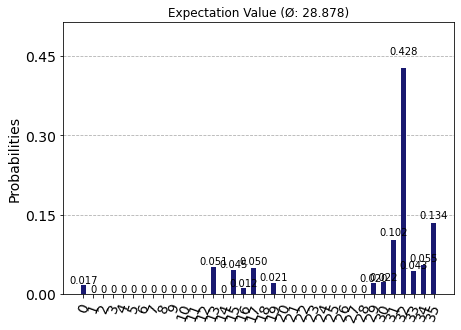

In [29]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
import mitiq
mitiq.about()
